In [3]:
import Bio.bgzf as bgzf
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.stats.api as sms
import scipy.stats as st
import seaborn as sns
from IPython.display import display, HTML


from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby

# Домашка 2. Выравнивание коротких ридов.
## Часть а. Анализ ридов Illumina

### Данные

Тестовый датасет: `test_1.fastq, test_2.fastq`<br>
Тестовый геном: `MG1655-K12.first10K.fasta`

Если ваша фамилия начинается на М-Я (моя фамилия на букву Ч):<br>
Датасет №1: `B.faecium/frag.R1.fastq.gz`, `B.faecium/frag.R2.fastq.gz`<br>
Датасет №2: `B.faecium/jump.R1.fastq.gz`, `B.faecium/jump.R2.fastq.gz`<br>
Референсный геном: `B.faecium/ref.fasta.gz*`<br>

Поехали!

#### 0. Разбораться с `Bowtie2` / `bwa mem`
Построить индекс, запустить любой из тулов на ваш выбор, определить процент приложившихся ридов (`samtools flagstat`). 

Выберу `bwa`.
<br>
Установим `bwa` and `samtools`
```
sudo apt-get install bwa
sudo apt-get install samtools
```
Далее, начнем работу с тестом:
индексируем, выравниваем, декобируем в бам и чекаем статистику:
```
$ bwa index MG1655-K12.first10K.fasta 
$ bwa mem MG1655-K12.first10K.fasta test_1.fastq test_2.fastq > alignment.sam
$ samtools view -S -b alignment.sam > alignment.bam
$ samtools flagstat alignment.bam
56320 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
56320 + 0 mapped (100.00% : N/A)
56320 + 0 paired in sequencing
28160 + 0 read1
28160 + 0 read2
56280 + 0 properly paired (99.93% : N/A)
56320 + 0 with itself and mate mapped
0 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

```
т.е. замапилось 99.93 процента

Для нормальных датасетов аналогично:
```
bwa index ref.fasta
bwa mem ref.fasta jump.R1.fastq jump.R2.fastq > alignment_jump.sam
samtools view -S -b alignment_jump.sam > alignment_jump.bam
bwa mem ref.fasta frag.R1.fastq frag.R2.fastq > alignment_frag.sam
samtools view -S -b alignment_frag.sam > alignment_frag.bam

```


### 1. Покрытие генома.
По SAM файлу:
* построить график покрытия генома, 
* определить среднее покрытие и долю покрытой области генома. 

Покрытие одной позиции в геноме есть количество ридов, приложившихся так, что их концы находятся по разные стороны от этой позиции. График можно строить усредняя, например, по 1000 нуклеотидов. 

Доля покрытой области генома определяется как процент нуклеотидов с ненулевым покрытием по отношению ко всей длине генома.

In [4]:
##### Подсчет покрытия
# Функция очень просто считает по строке cigar покрытие 
# возвращает массив "покрытие на каждый нуклеотид".
def count_cov(bam_file_path):
    
    bamfile = pysam.AlignmentFile(bam_file_path, 'rb')
    length = bamfile.lengths[0]
    
    
    base_cov = np.array([0 for i in range(length+1)])
    count = 0
    ex_counter = 0
    for read in bamfile:
        try:
            count += 1
            if count % 100000 == 0:
                print(count, end = ' ')
            if not read.is_unmapped:
                start = read.reference_start
                for tup in read.cigar:
                    s = start
                    f = start + tup[1]
                    if tup[0] == 8 or tup[0] == 7 or tup[0] == 1 or tup[0] == 0:  
                        for i in range(s, f):
                            base_cov[i] += 1
                    start = f
        except:
            ex_counter += 1
    print('\nРиды, при чтении которых возникла ошибка: '+str(ex_counter))
    return base_cov

#### Подсчет длины референсного генома.
# Берем из информационной строки sam-файла
def read_len(sam):
    samfile = open(sam, 'r')
    line_0 = samfile.readline()
    samfile.close()
    ln = int(line_0.split('\t')[2].replace('LN:',''))
    return ln

#### График покрытия генома

def draw_coverage(cov):
    length = len(cov)//1000 + 1
    new_cov = []
    positions = []
    for i in range(length):
        positions.append(i*1000)
        if i!=length-1:
            new_cov.append(np.average(cov[i*1000:(i+1)*1000]))
        else:
            new_cov.append(np.average(cov[i*1000:len(cov)]))
    positions = np.array(positions)
    new_cov = np.array(new_cov)
    plt.plot(positions, new_cov, linestyle="-", color = 'red')
    plt.show()
    
#### Среднее покрытие и доля покрытой области генома
def cov_stat(cov):
    avg = np.average(cov)
    zero_amount = np.count_nonzero(avg == 0)
    part_of_cov = 1 - zero_amount/len(cov)
    return avg, part_of_cov

##### Запустим на тесте!


Риды, при чтении которых возникла ошибка: 0
Среднее покрытие:508.92380761923806
Доля покрытия:1.0


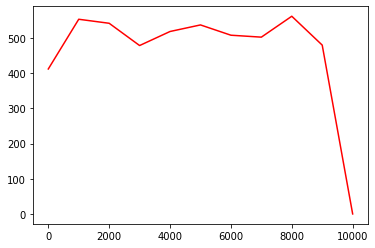

In [5]:
# Прочитаем файл, 

bam_test = 'data/test/alignment.bam'

# Посчитаем покрытие и статистики
coverage_test = np.array(count_cov(bam_test))
average_cov_test, part_of_cov_test = cov_stat(coverage_test)

# Выведем
print('Среднее покрытие:'+str(average_cov_test))
print('Доля покрытия:'+str(part_of_cov_test))

#Нарисуем график покрытия
draw_coverage(coverage_test)

### 2. Распределение расстояния вставки.
По SAM файлу:
* построить график распределения расстояния вставки, 
* определить среднее расстояние вставки, среднеквадратичное отклонение и интервал минимальной ширины, в который попадает 95% ридов. 

На графике по оси Х должно быть расстояние вставки, по оси Y — количество ридов в заданным расстоянием вставки.


In [8]:
#### Функция, возвращающая массив длин вставок
def insertion(bam_file_path):
    bam_file = pysam.AlignmentFile(bam_file_path, 'rb')
    ins = []
    count = 0
    for read in bam_file:
        count += 1
        if count % 100000 == 0:
            print(count, end = ' ')
        if not read.mate_is_unmapped:
            ins.append(abs(read.tlen))
    print()
    return  np.array(ins)


#### Посчитаем всякие нужные статистики
def count_stat(row):
    mean = np.mean(row)
    standart_d = np.std(row)
    interval = (np.percentile(row, 2.5), np.percentile(row, 97.5))
    treshold = np.percentile(row, 99) if np.percentile(row, 99)< 5000 else 5000
    sns.distplot(row[row<treshold])
    plt.show()
    return mean, standart_d, interval

##### Запустим на тесте

Посчитаем и выведем все, что нужно

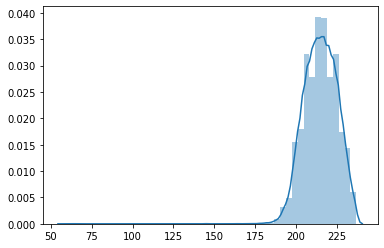

Cреднее расстояние вставки: 215.2860440340909
Cреднеквадратичное отклонение: 10.590040942453138
Интервал минимальной ширины, в который попадает 95% ридов: (196.0, 234.0)


In [9]:
# Прочитаем файл, 
bam_test = 'data/test/alignment.bam'

insert_test = insertion(bam_test)
mean_test, standart_d_test, interval_test = count_stat(insert_test)

# Выведем
print('Cреднее расстояние вставки: '+str(mean_test))
print('Cреднеквадратичное отклонение: '+str(standart_d_test))
print('Интервал минимальной ширины, в который попадает 95% ридов: '+str(interval_test))

### 3. Частоты различных замен
Построить матрицу частот замен (A,C,G,T).
Так, в ячейке (А,С) должно стоять количество ошибок замены С на А (С в референсе, А в риде). Определить средний процент ошибок в ридах.

In [6]:
def substitutions(bam_file_path):
    bam_file = pysam.AlignmentFile(bam_file_path, 'rb')
#     for i, read in enumerate(bam_file):
#         print(i, read)
    letter_to_digit = {'A':0, 'C':1, 'G':2, 'T':3}
    digit_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
    substitutions = [[0 for x in range(4)] for y in range(4)]
    sum_length = 0
    for read in bam_file:
        try:
            if not (read.is_supplementary and read.is_unmapped):
                ref_seq = read.get_reference_sequence()
                read_seq = read.query_alignment_sequence
                key_errors = 0
                for ref_l, read_l in zip(ref_seq, read_seq):
                    ref_l, read_l = ref_l.upper(), read_l.upper()
                    try:
                        if ref_l != read_l:
                            substitutions[letter_to_digit[read_l]][letter_to_digit[ref_l]]+=1
                    except KeyError:
                        key_errors+=1
                sum_length += len(ref_seq)-key_errors
        except ValueError:
            continue

        
            
    print(to_df(substitutions))
    print(f'Процент ошибок: {sum(sum(np.array(substitutions)))/sum_length*100} %')

def to_df(substitutions):
    numpy_data = np.array(substitutions)
    df = pd.DataFrame(data=numpy_data, index=['A', 'C', 'G', 'T'], columns=['A', 'C', 'G', 'T'])
    return df

In [7]:
substitutions(bam_test)

    A  C   G   T
A   0  0   0   0
C  15  0  21   0
G  19  2   0  16
T   1  1  34   0
Процент ошибок: 0.0021415602779470177 %


In [8]:
def run(bam):
    # ПОКРЫТИЕ
    print('COVERAGE\n')
    # Посчитаем покрытие и статистики
    coverage = np.array(count_cov(bam))
    average_cov, part_of_cov = cov_stat(coverage)

    # Выведем
    print('Среднее покрытие:'+str(average_cov))
    print('Доля покрытия:'+str(part_of_cov))

    #Нарисуем график покрытия
    draw_coverage(coverage)
    print('=====================')


    # РАССТОЯНИЕ ВСТАВКИ
    print('\nINSERTION DISTANCE\n')
    insert = insertion(bam)

    mean, standart_d, interval = count_stat(insert)
    # Выведем
    print('Cреднее расстояние вставки: '+str(mean))
    print('Cреднеквадратичное отклонение: '+str(standart_d))
    print('Интервал минимальной ширины, в который попадает 95% ридов: '+str(interval))

    print('=====================')

    # ЗАМЕНЫ
    print('\nSUBSTITUTIONS\n')
    substitutions(bam)


### Запустим на real data!

COVERAGE

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 
Риды, при чтении которых возникла ошибка: 47
Среднее покрытие:124.75544205906957
Доля покрытия:1.0


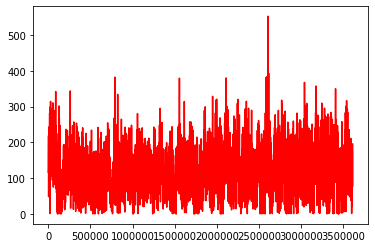


INSERTION DISTANCE

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 


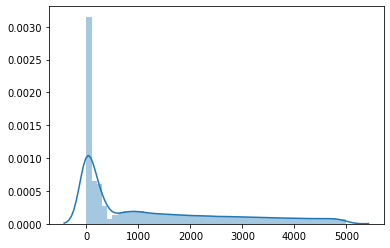

Cреднее расстояние вставки: 123755.02140813344
Cреднеквадратичное отклонение: 461252.2474377679
Интервал минимальной ширины, в который попадает 95% ридов: (1529.0, 1814088.9499999997)

SUBSTITUTIONS

        A       C       G       T
A       0  181760  120363   54794
C  911468       0  576392  554975
G  557167  588576       0  924135
T   60223  117102  181465       0
Процент ошибок: 1.070630985722677 %


In [15]:
run('data/B.faecium/alignment_jump.bam')


COVERAGE

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 
Риды, при чтении которых возникла ошибка: 23
Среднее покрытие:130.59156894399766
Доля покрытия:1.0


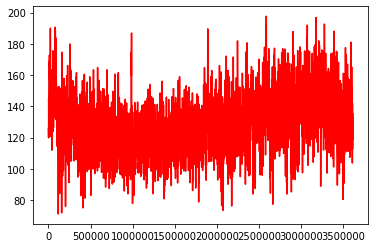


INSERTION DISTANCE

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 


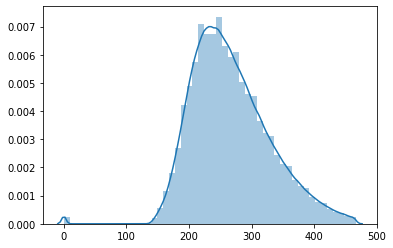

Cреднее расстояние вставки: 2360.175803007425
Cреднеквадратичное отклонение: 63249.24492436618
Интервал минимальной ширины, в который попадает 95% ридов: (172.0, 425.0)

SUBSTITUTIONS

         A        C        G        T
A        0   663614   325952   136337
C  1556651        0  1367740   946758
G   951439  1370383        0  1566515
T   133859   325154   665738        0
Процент ошибок: 2.120476278154807 %


In [10]:
run('data/B.faecium/alignment_frag.bam')

## Часть b. Анализ ридов IonTorrent
### Данные: 
Тестовые данные: `test.fastq`, `test_reference.fasta`

Данные: `B22-730.fastq.gz`, `C24-698.fastq.gz`

Референсный геном: `DH10B-K12.fasta`

Обработаем (тестовый не заработал ваще):
```
$ bwa index DH10B-K12.fasta 
$ bwa mem DH10B-K12.fasta B22-730.fastq >alignment_B.sam
$ samtools view -S -b alignment_B.sam > alignment_B.bam
$ bwa mem DH10B-K12.fasta C24-698.fastq >alignment_C.sam
$ samtools view -S -b alignment_C.sam > alignment_C.bam

```

### 1. Статистика ридов IonTorrent
С помощью посчитать следующие статистики для ридов:
* Покрытие генома (график, процент покрытого генома, среднее покрытие)
* Средний процент ошибок в ридах
* Статистика длин инделов
* Статистика длин инделов в завимости от длины гомополимерного участка (участок состоящий из одного типа нуклеотидов, например АААААААА). Мы фиксируем длину гомополимерного участка (пусть 5bp), и находим все гомополимеры такой длины в референсе. Дальше смотрим как участки этой длины прочитались секвенатором. Смотрим сколько раз прочиталось 3bp, 4bp, 5bp, 6bp и итд. Повторяем это для гомополимеров всех длин (например, от 3 до 20).
* Статистика качества нуклеотидов
    * при ошибочно вставленном нуклеотиде
    * при замене
* Таблица частот замен/вставок/удалений


In [111]:
def count_stats(bam_file_path):    
#     # покрытие:
#     coverage = np.array(count_cov(bam_file_path))
#     average_cov, part_of_cov = cov_stat(coverage)
#     print('Среднее покрытие:'+str(average_cov))
#     print('Доля покрытия:'+str(part_of_cov))
#     draw_coverage(coverage)
    # ошибки в ридах    

### Check this out:

100000 200000 300000 400000 
Риды, при чтении которых возникла ошибка: 7
Среднее покрытие:34.06491358129018
Доля покрытия:1.0


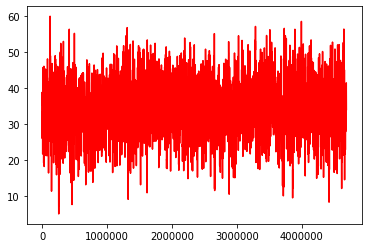

In [113]:
count_stats('data/2b/alignment_B.bam')

### And another data

In [ ]:
count_stats('data/2b/alignment_C.bam')